# Figs of Horizontal Turner Angles
## Table Of Contents: <a class="anchor" id="top"> </a>
* [Global annual-mean](#first-bullet)
* [Basin-wide annual-mean](#second-bullet)
* [Global timeseries?](#third-bullet)

> Note: the time dimension is only for first 6 months of CESM data

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pop_tools
import gcsfs
import fastjmd95

In [2]:
from intake import open_catalog
url = "https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean/CESM_POP.yaml"
cat = open_catalog(url)
cesm  = cat["CESM_POP_hires_control"].to_dask()
#workaround from Julius to make gradient func work quicker
ds_drop = cesm.drop([v for v in cesm.coords if v not in ['DXT', 'DXU', 'DYT', 'DYU', 'time']])

In [3]:
import json
with open('/home/jovyan/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

ta_clim = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/CESM/datasets/ta_clim.zarr'))
ta = ta_clim.ta_clim

In [4]:
#making it go to -90,90
ta = ta/2

In [5]:
from dask_gateway import Gateway
g = Gateway()
cluster = g.connect(g.list_clusters()[0].name)
client = cluster.get_client()

In [6]:
client

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/staging.ea4d6ac00d9242fa9fc572fb829663c1/status,


In [45]:
client.close()
cluster.close()

In [7]:
ta_mean = ta.mean('month').load()

## Make $\rho_0$ contours

In [8]:
rho_unsliced = fastjmd95.rho(ds_drop.SSS, ds_drop.SST, 0)
rho = rho_unsliced.isel(time=slice(0,182))
rho_mean = rho.mean('time').load()

In [9]:
rho_levs = np.arange(1024, 1029)

In [10]:
rho_levs

array([1024, 1025, 1026, 1027, 1028])

# 1) Global annual-mean <a class='anchor' id='first-bullet'> </a>

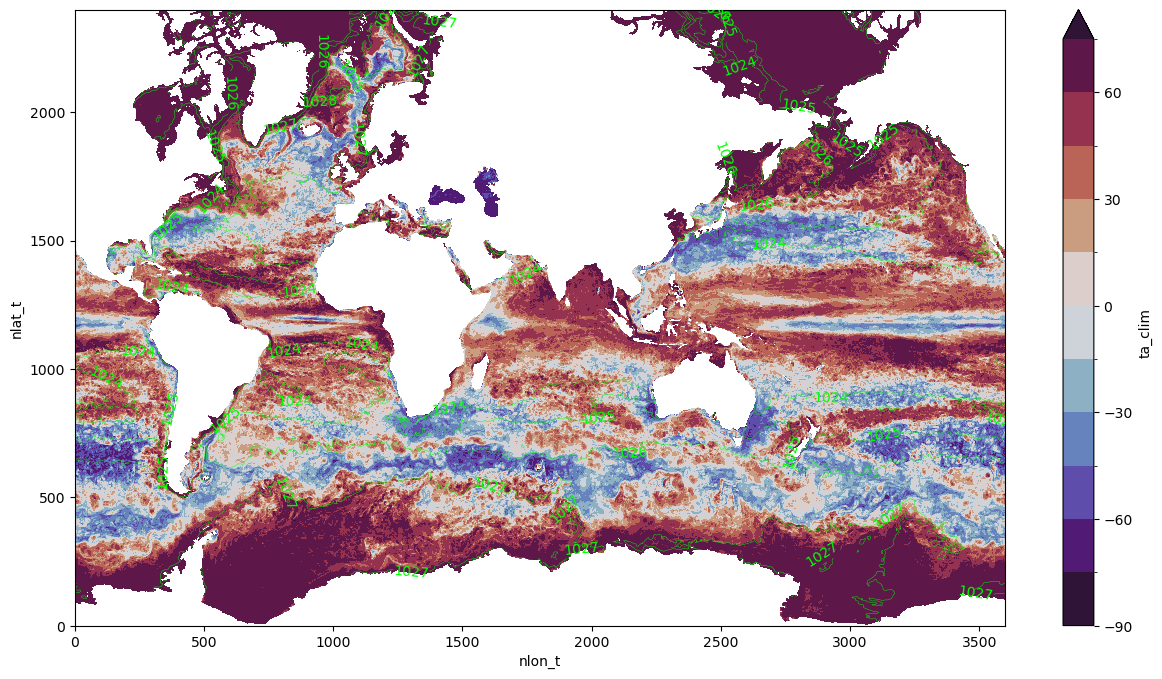

In [35]:
#global turner angle
fig, ax = plt.subplots(figsize=(15,8))

c = rho_mean.plot.contour(colors='lime', linewidths=0.3, levels=rho_levs)
plt.clabel(c)
ta_mean.plot.contourf(levels=np.arange(-90, 90, 15), cmap='twilight_shifted', ax=ax);

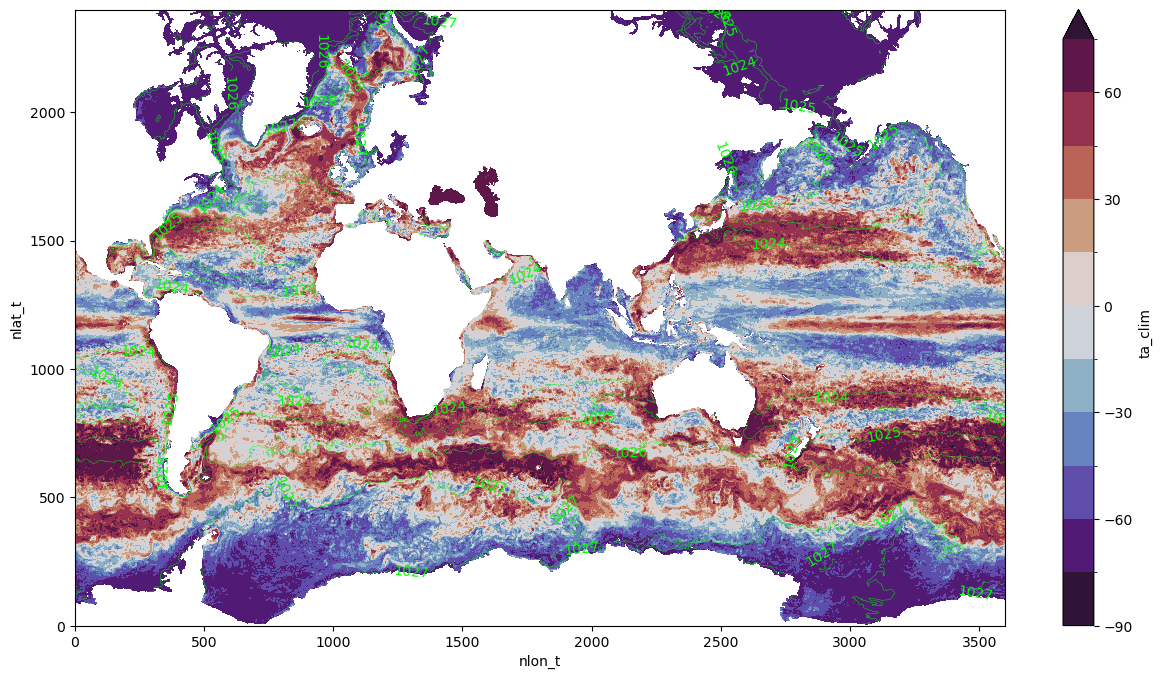

In [11]:
#global turner angle
fig, ax = plt.subplots(figsize=(15,8))

c = rho_mean.plot.contour(colors='lime', linewidths=0.3, levels=rho_levs)
plt.clabel(c)
(-ta_mean).plot.contourf(levels=np.arange(-90, 90, 15), cmap='twilight_shifted', ax=ax);

# 2) Basin-wide annual-mean <a class='anchor' id='second-bullet'> </a>

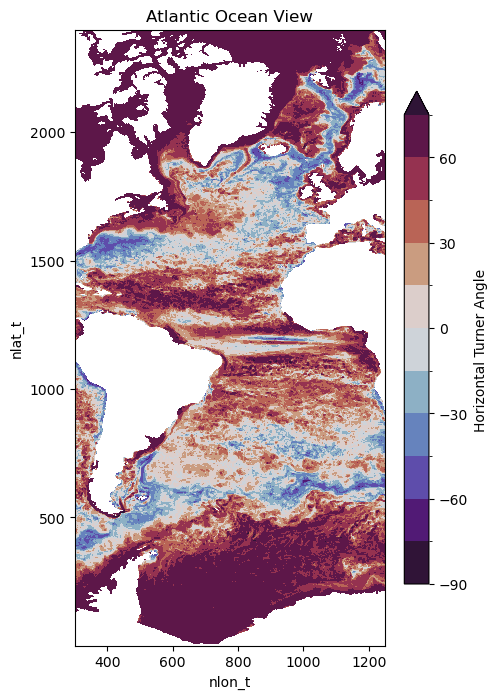

In [42]:
#ATL ocean
fig, ax = plt.subplots(figsize=(5,8))
ta_mean.isel(nlon_t=slice(300,1250)).plot.contourf(levels=np.arange(-90, 90, 15), ax=ax,
                                                    cmap='twilight_shifted',
                                                    cbar_kwargs={'shrink':0.8, 
                                                                 'label':'Horizontal Turner Angle'})
plt.title('Atlantic Ocean View');

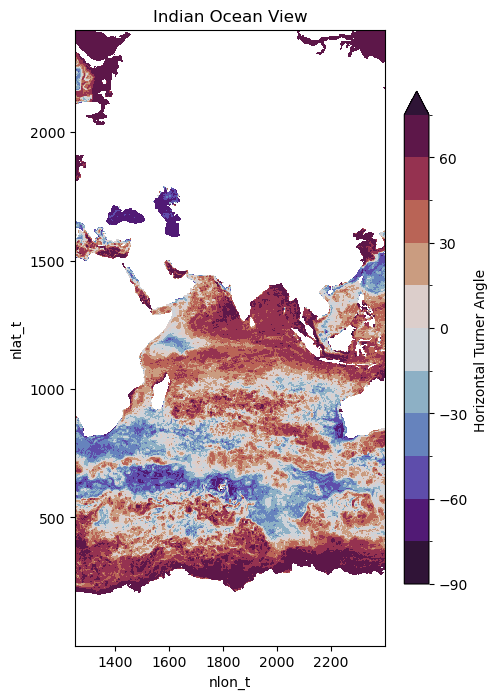

In [43]:
#IND ocean
fig, ax = plt.subplots(figsize=(5,8))
ta_mean.isel(nlon_t=slice(1250, 2400)).plot.contourf(levels=np.arange(-90, 90, 15), ax=ax,
                                                         cmap='twilight_shifted',
                                                         cbar_kwargs={'shrink':0.8, 
                                                                      'label':'Horizontal Turner Angle'})
plt.title('Indian Ocean View');

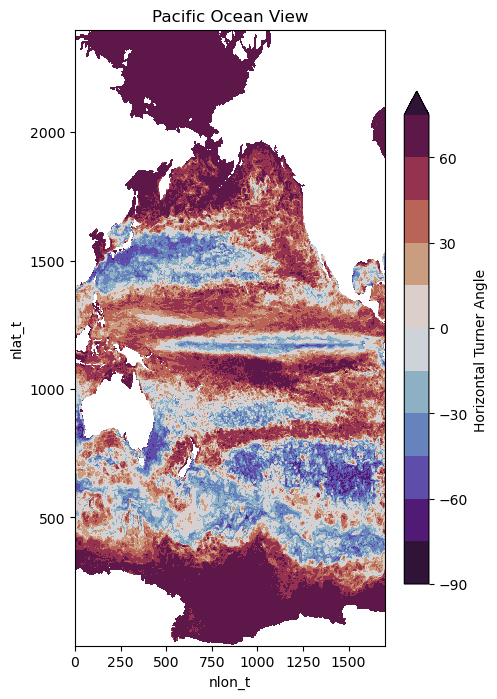

In [19]:
#PAC ocean
fig, ax = plt.subplots(figsize=(5,8))
pac_roll = ta_mean.roll(nlon_t=2400, roll_coords=True).isel(nlon_t=slice(1000,2700))
t = pac_roll.drop('nlon_t').plot.contourf(levels=np.arange(-90, 90, 15), 
                                          cmap='twilight_shifted',
                                          cbar_kwargs={'shrink':0.8, 
                                                       'label':'Horizontal Turner Angle'})
plt.title('Pacific Ocean View');

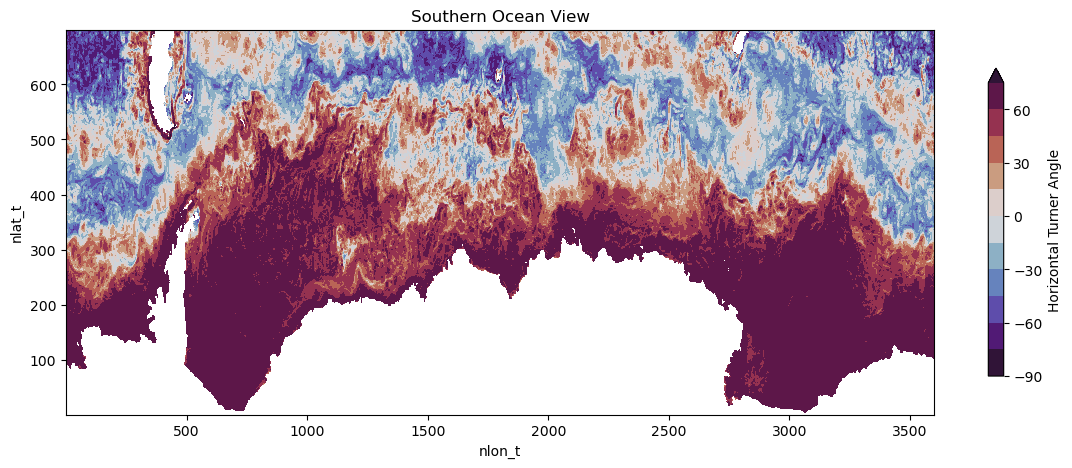

In [21]:
#SO ocean
fig, ax = plt.subplots(figsize=(14,5))
t = ta_mean.isel(nlat_t=slice(0, 700)).plot.contourf(levels=np.arange(-90, 90, 15), 
                                                     cmap='twilight_shifted',
                                                     cbar_kwargs={'shrink':0.8, 
                                                                  'label':'Horizontal Turner Angle'})
plt.title('Southern Ocean View');

# 3) Global timeseries <a class='anchor' id='third-bullet'> </a>

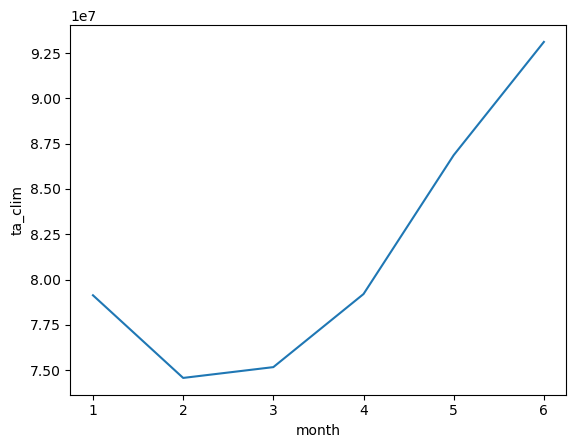

In [32]:
ta.sum(('nlon_t', 'nlat_t')).plot()